## Group : 14 
## Project 1 

## Part 1: Data loading
Here we are going to load the images into memory in format that will work well for the training of the model. 

Import the mods that will be used for this project

In [61]:
import pandas as pd
import os
from PIL import Image
# Note that you must install the following on your
# machine to get this program to work
from cvzone.HandTrackingModule import HandDetector
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import keras




Normalizing all images to a standard formate and highlighting the key points on the hands. This 
will also clean and remove images were the hands can not be detected. Once all files are normalized 
a normalized file is dropped in the directory so this wont be called again. 

In [ ]:
detector = HandDetector(maxHands=1,detectionCon=.9, minTrackCon=.9)

# Here we detect the hand. If detected we 
# resize and store it down. If not detected 
# we remove the file.
def normalizeImageHandler(path):

    image = cv2.imread(path) 

    offset = 20
    
    hands, img = detector.findHands(image) 

    if hands :
        
        hand = hands[0]

        x, y, w, h = hand['bbox']

        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        try :
            
            if img.shape[0] <= 50 or img.shape[1] <=50:
              raise ValueError("Hand dection image corrupted")
            
            image = Image.fromarray(cv2.cvtColor(imgCrop, cv2.COLOR_BGR2RGB))

            image = image.resize((200, 200))   

            # Convert the PIL image back to OpenCV format
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            cv2.imwrite(path,image)
           
        except:
          os.remove(path)

   
          
# Function and entry point to 
# normalize all of the images
def normalizeImages():
        train_folder = './asl_alphabet_train'
        for folder in os.listdir(train_folder):
          label_folder = os.path.join(train_folder, folder)
          if not os.path.isfile(label_folder):
            [ \
              normalizeImageHandler(os.path.join(label_folder,f)) \
              for f in os.listdir(label_folder) \
              if os.path.isfile(os.path.join(label_folder, f)) \
            ]
       
normalizeImages()

<img src="images/A381.jpg" alt="Image Title" style="margin: 20px">
<img src="images/A381_N.jpg" alt="Image Title" style="margin: 20px">
<img src="images/L29.jpg" alt="Image Title" style="margin: 20px">
<img src="images/L29_N.jpg" alt="Image Title" style="margin: 20px">

Load data into memory

In [51]:
train_folder = './asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    if not os.path.isfile(label_folder):
        onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
        all_data += onlyfiles
        data_df = pd.DataFrame(all_data)
data_df

,label,path
0,R,./asl_alphabet_train/R/R2837.jpg
1,R,./asl_alphabet_train/R/R1494.jpg
2,R,./asl_alphabet_train/R/R228.jpg
3,R,./asl_alphabet_train/R/R200.jpg
4,R,./asl_alphabet_train/R/R566.jpg
...,...,...
48749,W,./asl_alphabet_train/W/W375.jpg
48750,W,./asl_alphabet_train/W/W1286.jpg
48751,W,./asl_alphabet_train/W/W1292.jpg
48752,W,./asl_alphabet_train/W/W361.jpg


# Part 2: Model Creation
Creation of the model class that will be used to train and test the model.

In [52]:
model = Sequential()

model.add(Conv2D(filters = 15, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (200,200,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(28, activation = "softmax"))

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 15)      1140      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 15)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 15)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      12032     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 32)        0

# Part 3: Train the model


Splitting of the test and training set.

In [53]:
img_size = 200
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

x_train,test_set = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])

x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col=x_col, 
    y_col=y_col,
    target_size=(img_size, img_size),
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, 
    x_col=x_col, 
    y_col=y_col,
    target_size=(img_size, img_size), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False
)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set, 
    x_col=x_col, 
    y_col=y_col,
    target_size=(img_size, img_size), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False
)



Found 32908 validated image filenames belonging to 28 classes.
Found 10970 validated image filenames belonging to 28 classes.
Found 4876 validated image filenames belonging to 28 classes.


Here we are going to be executing and training the model.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=50

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
258/258 [==============================] - 713s 3s/step - loss: 0.9879 - accuracy: 0.7289 - val_loss: 0.3633 - val_accuracy: 0.9051
Epoch 2/50
258/258 [==============================] - 700s 3s/step - loss: 0.2678 - accuracy: 0.9239 - val_loss: 0.2530 - val_accuracy: 0.9334
Epoch 3/50
258/258 [==============================] - 704s 3s/step - loss: 0.1719 - accuracy: 0.9487 - val_loss: 0.2009 - val_accuracy: 0.9420
Epoch 4/50
258/258 [==============================] - 704s 3s/step - loss: 0.1196 - accuracy: 0.9633 - val_loss: 0.1770 - val_accuracy: 0.9526
Epoch 5/50
258/258 [==============================] - 693s 3s/step - loss: 0.0823 - accuracy: 0.9731 - val_loss: 0.1729 - val_accuracy: 0.9542
Epoch 6/50
258/258 [==============================] - 700s 3s/step - loss: 0.0644 - accuracy: 0.9787 - val_loss: 0.1564 - val_accuracy: 0.9591
Epoch 7/50
258/258 [==============================] - 4530s 18s/step - loss: 0.0483 - accuracy: 0.9847 - val_loss: 0.1765 - val_accuracy: 0.95

Visualization of training results

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


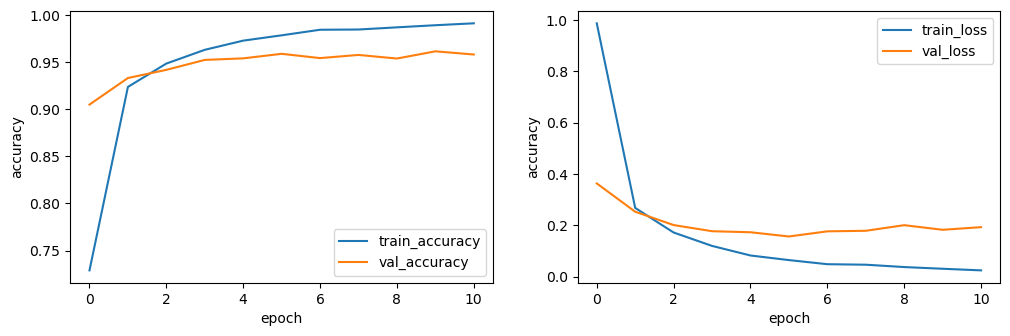

In [9]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.figure(figsize=(12,12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Part 4: Test the model

In [10]:
# Print the test results
predictions = model.predict(test_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)


39/39 [==============================] - 26s 668ms/step


# Part 5: Visualization of test results

In [11]:
# Print display the test results using one 
# of the graphs for data modeling 
print(report)

# Save model for later use
model.save('ASL_class.h5')

# Store down labels 
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_labels))


              precision    recall  f1-score   support

           A       0.90      0.98      0.94       173
           B       0.97      0.97      0.97       172
           C       0.99      0.99      0.99       176
           D       0.98      0.98      0.98       202
           E       0.94      0.96      0.95       196
           F       0.97      0.98      0.98       218
           G       0.95      0.96      0.96       160
           H       0.98      0.97      0.97       205
           I       0.96      0.95      0.95       200
           J       0.97      0.98      0.98       177
           K       0.94      0.95      0.94       190
           L       1.00      0.98      0.99       216
           M       0.93      0.91      0.92       126
           N       0.94      0.91      0.92        98
           O       0.99      0.96      0.98       180
           P       0.96      0.99      0.98       164
           Q       0.98      0.93      0.95       135
           R       0.94    

# Part 6: Program Execution Live
Test the model on the test set folder and display  all results 

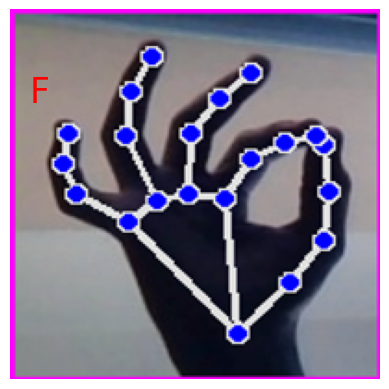

./asl_alphabet_test/F_test.jpg


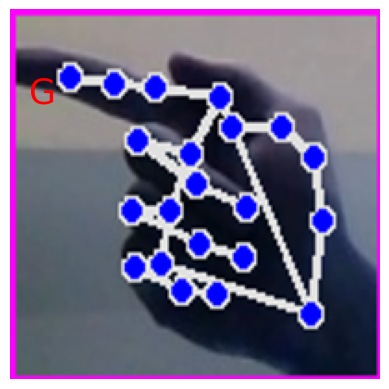

./asl_alphabet_test/G_test.jpg


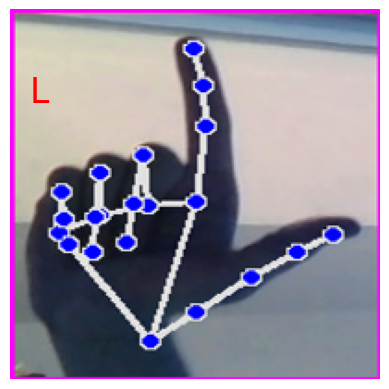

./asl_alphabet_test/L_test.jpg


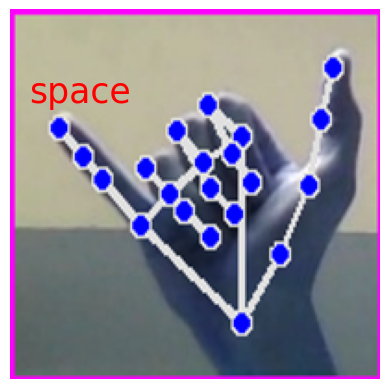

./asl_alphabet_test/Y_test.jpg


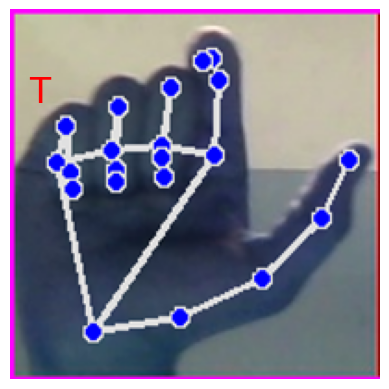

./asl_alphabet_test/T_test.jpg


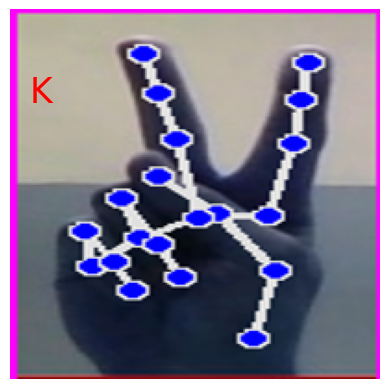

./asl_alphabet_test/K_test.jpg


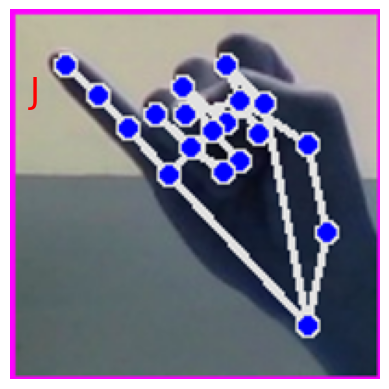

./asl_alphabet_test/J_test.jpg


In [54]:

import cv2
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import keras

# load the saved model
model = keras.models.load_model("ASL_class.h5")

detector = HandDetector(maxHands=1,detectionCon=.9, minTrackCon=.9)

offset = 20

with open("labels.txt", 'r') as f:
    labels = f.read().split('\n')

test_folder = './asl_alphabet_test'

for file in os.listdir(test_folder):
    path = os.path.join(test_folder, file)

    image = cv2.imread(path) 
    
    hands, img = detector.findHands(image) 

    if hands :
        hand = hands[0]

        x, y, w, h = hand['bbox']

        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        try :
            image = Image.fromarray(cv2.cvtColor(imgCrop, cv2.COLOR_BGR2RGB))

            image = image.resize((200, 200))   

            # Convert the PIL image back to OpenCV format
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            plt.imshow(image)

            # Feed the image to the model
            pred = model.predict(image.reshape(1,200,200,3), verbose=0)

            # Get the predicted class index
            pred_class = np.argmax(pred, axis=1)

            plt.axis('off')

            # Add label to the image
            plt.text(10, 50, labels[pred_class[0]], fontsize=25, color='red')

            plt.show()

            # Printing the true label 
            print(path)
           
        except: 
           break
